In [1]:
# Set all seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf

# Set seeds
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Enable deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Force TensorFlow to use single thread
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


In [3]:
#I always put this just so the code cells show all outputs and not just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Rental Appraisal Neural Network (Gradstay)

The purpose of this notebook is to create an ML model to predict rental price based on scraped JSON data of property listing in london. This model will be used as an assistant to help landlords estimate the returns they can expect for their properties.

## Transforming Data to Parquet/EDA

In [4]:
# Load the JSON file
with open('propertydata.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Convert 'studio' to '1' in bedrooms column
df['bedrooms'] = df['bedrooms'].replace('studio', '1')
# Convert bedrooms to integer type
df['bedrooms'] = pd.to_numeric(df['bedrooms'])

# Drop the problematic columns
df = df.drop(['dateAvailable', 'createdAt', 'lastUpdated'], axis=1)

df.to_csv('propertydata.csv')
# Convert DataFrame to Parquet
df.to_parquet('propertydata.parquet')

# Load the Parquet file back to ensure it's correctly saved
df = pd.read_parquet('propertydata.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   address              7789 non-null   object 
 1   postcode             7789 non-null   object 
 2   postalDistrict       7789 non-null   object 
 3   longitude            7789 non-null   float64
 4   latitude             7789 non-null   float64
 5   geoHash              7789 non-null   object 
 6   price                7789 non-null   float64
 7   bedrooms             7789 non-null   int64  
 8   bathrooms            5620 non-null   float64
 9   isFurnished          7789 non-null   bool   
 10  isLive               7789 non-null   bool   
 11  title                7789 non-null   object 
 12  description          7789 non-null   object 
 13  termLength           6880 non-null   object 
 14  listings             7789 non-null   object 
 15  propertyId           7789 non-null   o

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='price', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Rental Prices')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Frequency')

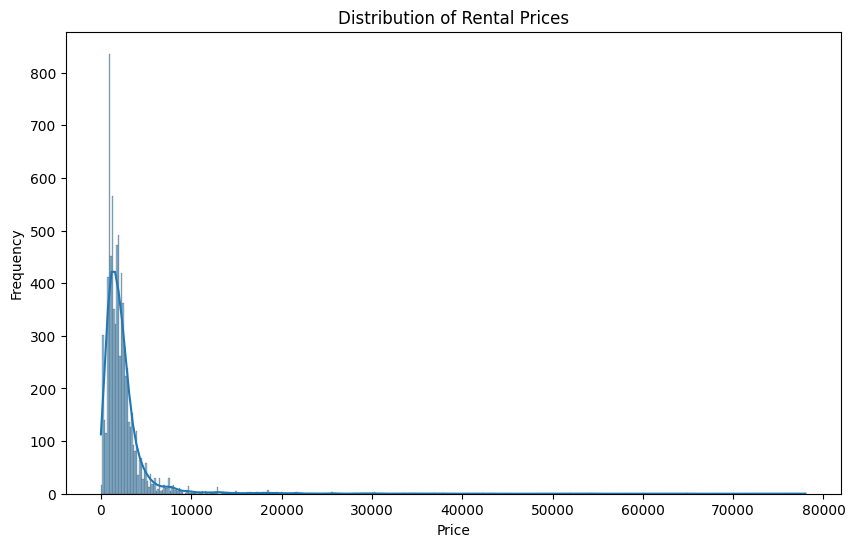

In [5]:

# Display basic info
print(df.info())

# Display summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize the distribution of the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Predictions/Hypotheses:

The model will perform worse on properties with higher rental prices given the right skew of the distribution. 

Square footage may be a limiting factor as an ommited variable due to data collection constraints.



### Initial Analysis

Features to drop:

    address: (too unique and not structured)

    propertyId: (simply an identifier)

    roomDetails: (empty)

    isLive: (not contributing to price prediction)

    availiableRooms: not enough data

    occupantPreferences: not enough data


    listings: simply urls


Features to use as is:

    longitude 

    latitude

    price
    
    bedrooms, bathrooms
    

Categorical Features needing encoding:

    postcode (important and needs embeddings)

    postalDistrict (might be useful but may overlap)

    isFurnished (convert to binary)

    termLength (convert short/long to binary)

    isSharedProperty: convert all missing/FALSE to 0, TRUE to 1

    geohash

## Feature Engineering

In [6]:
# Feature Engineering

# 1. Convert isFurnished to binary
df['isFurnished'] = df['isFurnished'].map({'true': 1, 'false': 0, True: 1, False: 0}).fillna(0)

# 2. Convert termLength to binary (assuming 'short' and 'long' are the values)
df['termLength'] = df['termLength'].map({'short': 0, 'long': 1}).fillna(0)

# 3. Convert isSharedProperty to binary
df['isSharedProperty'] = df['isSharedProperty'].map({True: 1, False: 0, 'TRUE': 1, 'FALSE': 0}).fillna(0)

# 4. Create postcode embeddings using the first part of the postcode
df['postcode_prefix'] = df['postcode'].str.split().str[0]

# 5. Create dummy variables for postcode_prefix (one-hot encoding)
postcode_dummies = pd.get_dummies(df['postcode_prefix'], prefix='postcode')
df = pd.concat([df, postcode_dummies], axis=1)

# 6. Create dummy variables for postalDistrict
district_dummies = pd.get_dummies(df['postalDistrict'], prefix='district')
df = pd.concat([df, district_dummies], axis=1)

# Drop the original categorical columns if no longer needed
df = df.drop(['postcode', 'postcode_prefix', 'postalDistrict'], axis=1)

# Drop the columns identified as irrelevant

df = df.drop(['address', 'propertyId', 'roomDetails', 'isLive', 'availableRooms', 'occupantPreferences', 'listings', 'totalRooms', 'title', 'description'], axis = 1)

# Save the engineered dataset
df.to_parquet('propertydata_engineered.parquet')
df.to_csv('propertydata_engineered.csv')

In [7]:
print(df.describe())


         longitude     latitude         price     bedrooms    bathrooms  \
count  7789.000000  7789.000000   7789.000000  7789.000000  5620.000000   
mean     -0.124599    51.510875   2459.619136     1.813840     1.461922   
std       0.071872     0.039871   3211.258414     1.247497     0.818331   
min      -0.314330    51.391365      1.000000     1.000000     1.000000   
25%      -0.178761    51.487924   1075.000000     1.000000     1.000000   
50%      -0.125035    51.512648   1842.000000     1.000000     1.000000   
75%      -0.077698    51.537155   2750.000000     2.000000     2.000000   
max       0.058998    51.623558  78000.000000    34.000000    20.000000   

       isFurnished   termLength  isSharedProperty  
count  7789.000000  7789.000000       7789.000000  
mean      0.795994     0.666966          0.008088  
std       0.402999     0.471329          0.089576  
min       0.000000     0.000000          0.000000  
25%       1.000000     0.000000          0.000000  
50%       1.

The creation of binary variables for different combinations of postcodes makes the columns/features of our dataset much larger, this is reflected in the shape of the engineered dataset being 7789 by 402.

In [8]:
# Verify the transformations
print("Binary columns:")
print(df[['isFurnished', 'termLength', 'isSharedProperty']].head())
print("\nShape of engineered dataset:", df.shape)

print(df.isnull().sum())

Binary columns:
   isFurnished  termLength  isSharedProperty
0            0         1.0               0.0
1            1         1.0               0.0
2            1         0.0               0.0
3            1         1.0               0.0
4            1         1.0               0.0

Shape of engineered dataset: (7789, 399)
longitude        0
latitude         0
geoHash          0
price            0
bedrooms         0
                ..
district_WC2N    0
district_WC2R    0
district_WORK    0
district_YARD    0
district_YORK    0
Length: 399, dtype: int64


## Model Training and Selection

First we drop the geoHash column as we have longitude and latitude. We then seperate the price feature from the rest of the dataframe as that will be our target variable. Then, I test a simple random forest model to see how it performs with the default parameters and as a baseline for my neural network.

In [9]:
# Check if price is in the columns
print("'price' in columns:", 'price' in df.columns)

# Show all remaining columns
print("\nAll columns:")
print(df.columns.tolist())

'price' in columns: True

All columns:
['longitude', 'latitude', 'geoHash', 'price', 'bedrooms', 'bathrooms', 'isFurnished', 'termLength', 'isSharedProperty', 'postcode_ACRE', 'postcode_AIRD', 'postcode_AIRY', 'postcode_ARK', 'postcode_BARRY', 'postcode_BERRY', 'postcode_BR1', 'postcode_BR3', 'postcode_CR4', 'postcode_CR7', 'postcode_E1', 'postcode_E10', 'postcode_E11', 'postcode_E12', 'postcode_E13', 'postcode_E14', 'postcode_E15', 'postcode_E16', 'postcode_E17', 'postcode_E1W', 'postcode_E2', 'postcode_E20', 'postcode_E22', 'postcode_E3', 'postcode_E5', 'postcode_E6', 'postcode_E7', 'postcode_E8', 'postcode_E9', 'postcode_EC1', 'postcode_EC1A', 'postcode_EC1M', 'postcode_EC1N', 'postcode_EC1R', 'postcode_EC1V', 'postcode_EC1Y', 'postcode_EC2A', 'postcode_EC2Y', 'postcode_EC3A', 'postcode_EC4A', 'postcode_EC4R', 'postcode_EC4V', 'postcode_EN2', 'postcode_FARM', 'postcode_FIRS', 'postcode_FORD', 'postcode_GORE', 'postcode_HA0', 'postcode_HA9', 'postcode_HARP', 'postcode_HART', 'postcod

In [10]:
# Drop geohash column since we already have longitude and latitude
X = df.drop(['price', 'geoHash'], axis=1)
y = df['price']

# First split: separate test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate train and validation sets (80% train, 20% validation of remaining data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # number of trees
    max_depth=None,    # maximum depth of trees
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
train_pred = rf_model.predict(X_train)
val_pred = rf_model.predict(X_val)
test_pred = rf_model.predict(X_test)

# Calculate RMSE and R² for all sets
def evaluate_predictions(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:.2f}")
    print(f"R²: {r2:.3f}")

evaluate_predictions(y_train, train_pred, "Training")
evaluate_predictions(y_val, val_pred, "Validation")
evaluate_predictions(y_test, test_pred, "Test")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

RandomForestRegressor(random_state=42)


Training Results:
RMSE: £762.48
R²: 0.943

Validation Results:
RMSE: £2162.05
R²: 0.638

Test Results:
RMSE: £1705.64
R²: 0.659

Top 10 Most Important Features:
           feature  importance
3        bathrooms    0.315965
0        longitude    0.124294
4      isFurnished    0.120628
1         latitude    0.105035
2         bedrooms    0.045286
145  postcode_SW1X    0.029254
340  district_SW1X    0.027959
153   postcode_SW7    0.024627
348   district_SW7    0.021257
344   district_SW3    0.015526


Now we can create a simple neural network model using keras and see if it performs better.

NaN values in features: 2169
NaN values in target: 0

After splitting:
NaN in X_train: 0
NaN in X_val: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_val: 0
NaN in y_test: 0

After scaling:
NaN in X_train_scaled: 0
NaN in X_val_scaled: 0
NaN in X_test_scaled: 0
Epoch 1/1000


2025-02-10 14:40:47.411159: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-02-10 14:40:47.411874: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 16432772.0000 - val_loss: 18816768.0000
Epoch 2/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 16099910.0000 - val_loss: 17481788.0000
Epoch 3/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 14168969.0000 - val_loss: 14086216.0000
Epoch 4/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 10663200.0000 - val_loss: 11551970.0000
Epoch 5/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 8549865.0000 - val_loss: 10810954.0000
Epoch 6/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 8006546.5000 - val_loss: 10488800.0000
Epoch 7/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 7679115.5000 - val_loss: 10244181.0000
Epoch 8/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 7414766.0000 - val_loss: 10035222.0000
Epoch 9/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 7201310.5000 - val_loss: 9853782.0000
Epoch 10/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 7005494.5000 - val

2025-02-10 14:41:41.537165: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:41:41.537478: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

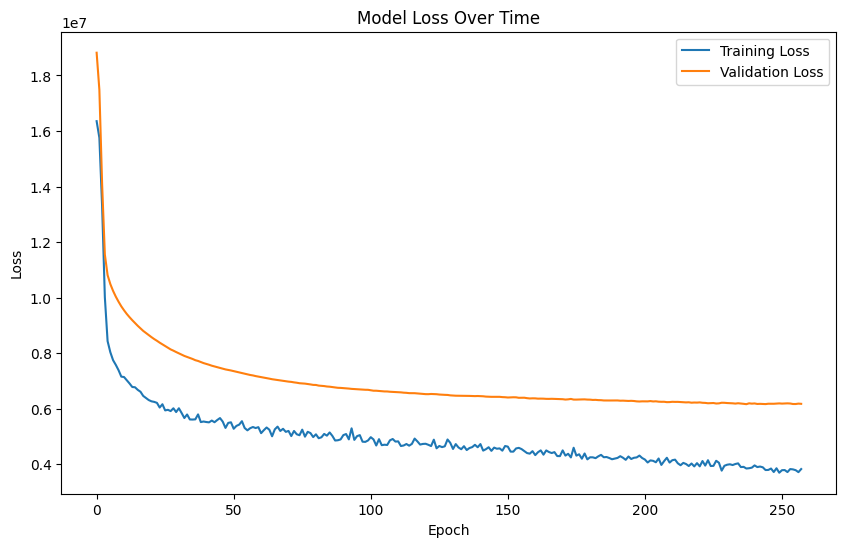

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

# 1. Check for and handle NaN values
print("NaN values in features:", X.isnull().sum().sum())
print("NaN values in target:", y.isnull().sum())

# Fill NaN values in the full dataset
X = X.fillna(X.mean())  # Fill numeric columns with mean
y = y.fillna(y.mean())  # Fill target with mean

# 2. Create train/val/test splits
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# 3. Check for NaN values after splitting
print("\nAfter splitting:")
print("NaN in X_train:", np.isnan(X_train).sum().sum())
print("NaN in X_val:", np.isnan(X_val).sum().sum())
print("NaN in X_test:", np.isnan(X_test).sum().sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("NaN in y_val:", np.isnan(y_val).sum())
print("NaN in y_test:", np.isnan(y_test).sum())

# 4. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Check for NaN values after scaling
print("\nAfter scaling:")
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).sum().sum())
print("NaN in X_val_scaled:", np.isnan(X_val_scaled).sum().sum())
print("NaN in X_test_scaled:", np.isnan(X_test_scaled).sum().sum())

# Get input shape
input_dim = X_train.shape[1]

# 6. Create the model: This has 1 input layer, 3 hidden layers, 2 dropout layers and 1 output layer
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'), #128 neurons
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'), #64 neurons
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'), #32 neurons
    layers.Dense(1)
])

# 7. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse'
)

# 8. Train the model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=1000,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# 9. Evaluate the model
def evaluate_nn_predictions(model, X_scaled, y_true, set_name):
    y_pred = model.predict(X_scaled)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:.2f}")
    print(f"R²: {r2:.3f}")

# Evaluate on all sets
evaluate_nn_predictions(model, X_train_scaled, y_train, "Training")
evaluate_nn_predictions(model, X_val_scaled, y_val, "Validation")
evaluate_nn_predictions(model, X_test_scaled, y_test, "Test")

# 10. Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

Clearly, this first model is not performing well. I will now try to improve the model by changing the parameters and adding more layers.

Possible Improvements Regarding Feature Engineering: 
- Adding feature interactions such as bedrooms x bathrooms
- Create polynomial features for important numerical columns
- There could be a diminishing effect for additional bedrooms which means a polynomial relationship would better work for our model

NaN values in features: 6507
NaN values in target: 0
Epoch 1/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 16453347.0000 - val_loss: 18934130.0000
Epoch 2/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 16351470.0000 - val_loss: 18453568.0000
Epoch 3/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 15545165.0000 - val_loss: 16340283.0000
Epoch 4/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 12926865.0000 - val_loss: 13011352.0000
Epoch 5/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 9788754.0000 - val_loss: 11101296.0000
Epoch 6/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 8332166.5000 - val_loss: 10506251.0000
Epoch 7/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 7802239.0000 - val_loss: 10212630.0000
Epoch 8/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 7566655.5000 - val_loss: 10001513.0000
Epoch 9/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 7759868.5000 - val_loss: 9836941.0000
Epoch 10/1000
312

2025-02-10 14:42:32.098896: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:42:32.099218: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Test Results:
RMSE: £1995.51
R²: 0.534


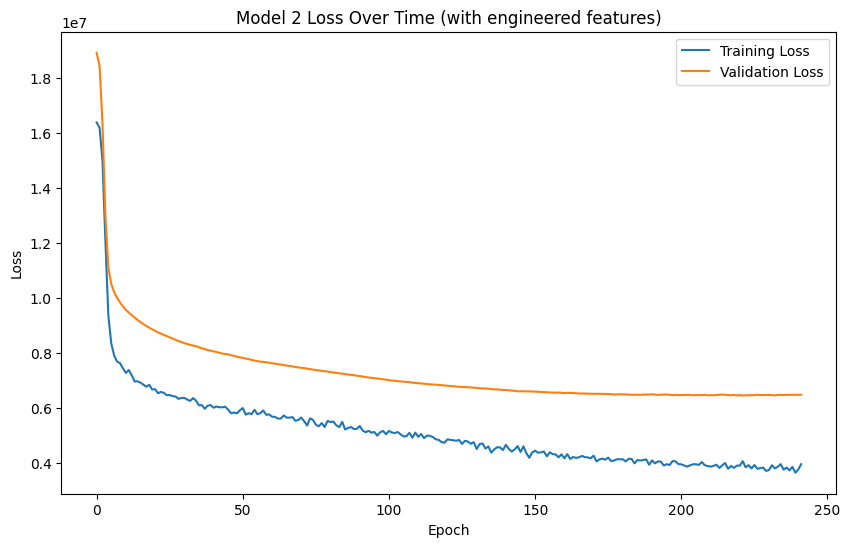

In [12]:
# Set global random seeds
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

# Create a copy of the original dataset
df_2 = df.copy()

# Add feature interactions
df_2['bedrooms_bathrooms'] = df_2['bedrooms'] * df_2['bathrooms']

# Add polynomial features for bedrooms and bathrooms
df_2['bedrooms_squared'] = df_2['bedrooms'] ** 2
df_2['bathrooms_squared'] = df_2['bathrooms'] ** 2

# Prepare features and target for new model
X_2 = df_2.drop(['price', 'geoHash'], axis=1)
y_2 = df_2['price']

# Check for and handle NaN values
print("NaN values in features:", X_2.isnull().sum().sum())
print("NaN values in target:", y_2.isnull().sum())

# Fill NaN values in the full dataset
X_2 = X_2.fillna(X_2.mean())  # Fill numeric columns with mean
y_2 = y_2.fillna(y_2.mean())  # Fill target with mean

# Split the data
X_train_val_2, X_test_2, y_train_val_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.2, random_state=42
)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(
    X_train_val_2, y_train_val_2, test_size=0.2, random_state=42
)

# Scale the features
scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_val_scaled_2 = scaler_2.transform(X_val_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)

# Create the second model
input_dim_2 = X_train_2.shape[1]  # New input dimension with engineered features

model2 = keras.Sequential([
    layers.Input(shape=(input_dim_2,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile model2
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse'
)

# Train model2
early_stopping_2 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history2 = model2.fit(
    X_train_scaled_2, y_train_2,
    validation_data=(X_val_scaled_2, y_val_2),
    epochs=1000,
    batch_size=16,
    callbacks=[early_stopping_2],
    verbose=1
)

# Evaluate model2
print("\nModel 2 Results (with engineered features):")
evaluate_nn_predictions(model2, X_train_scaled_2, y_train_2, "Training")
evaluate_nn_predictions(model2, X_val_scaled_2, y_val_2, "Validation")
evaluate_nn_predictions(model2, X_test_scaled_2, y_test_2, "Test")

# Plot training history for model2
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss Over Time (with engineered features)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

Model 2 Performs slightly better but there are still some changes we can make:

One route we could take is to use a log transformation on our output variable while keeping our input featrues exactly the same.

In this workflow
1. Train the model on log prices
2. Save the model and scaler
3. In deployment: Scale new input, get log prediction, convert back to price

Note, this does not mean we are using the actual price in prediction, we are just using the log transform as apart of the model's internal training process.



Training set shape: (4984, 400)
Validation set shape: (1247, 400)
Test set shape: (1558, 400)
Epoch 1/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 57.8511 - mae: 7.4142 - val_loss: 50.0334 - val_mae: 7.0023 - learning_rate: 1.0000e-04
Epoch 2/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 52.7271 - mae: 7.1406 - val_loss: 46.5177 - val_mae: 6.7643 - learning_rate: 1.0000e-04
Epoch 3/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 47.9322 - mae: 6.8222 - val_loss: 41.8598 - val_mae: 6.4156 - learning_rate: 1.0000e-04
Epoch 4/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 42.4705 - mae: 6.4144 - val_loss: 35.9582 - val_mae: 5.9406 - learning_rate: 1.0000e-04
Epoch 5/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 36.3601 - mae: 5.9105 - val_loss: 29.9147 - val_mae: 5.4025 - learning_rate: 1.0000e-04
Epoch 6/1000
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 29.8889 - mae: 5.3258 - val_loss: 23.5670 - val_mae: 4.7832 - learning_rate: 1.0000e

2025-02-10 14:43:06.003019: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:43:06.003346: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Validation Results:
RMSE: £2559.04
R²: 0.493
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step

Test Results:
RMSE: £2223.38
R²: 0.421


<Figure size 1500x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model 3 Loss Over Time')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss (MSE)')

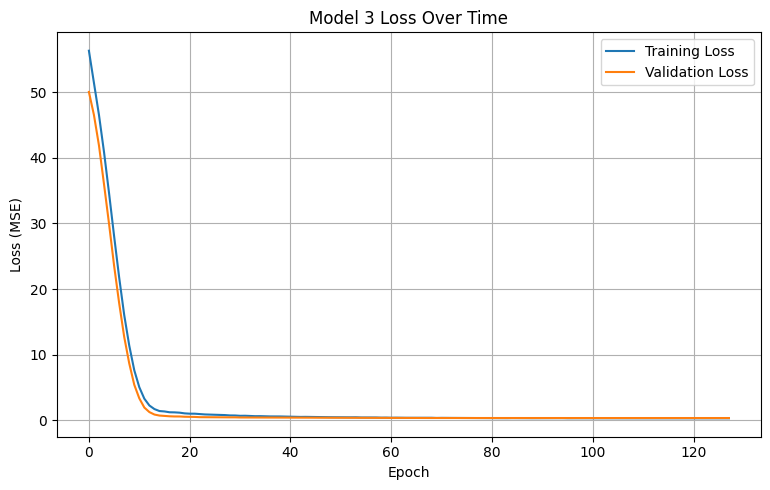


Final Metrics Summary:
Training   - RMSE: £2443.14, R²: 0.415
Validation - RMSE: £2559.04, R²: 0.493
Test       - RMSE: £2223.38, R²: 0.421


In [13]:
# Set global random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Create copy of df_2 for new model
df_3 = df_2.copy()

# Prepare features (X) and target (y)
X_3 = df_3.drop(['price', 'geoHash'], axis=1)
y_3 = df_3['price']

# Fill NaN values in features with mean of each column
for column in X_3.columns:
    X_3[column] = X_3[column].fillna(X_3[column].mean())

# Fill NaN values in target
y_3 = y_3.fillna(y_3.mean())

# Transform target to log space
y_3_log = np.log1p(y_3)

# Split data BEFORE scaling
X_train_val_3, X_test_3, y_train_val_3_log, y_test_3_log = train_test_split(
    X_3, y_3_log, test_size=0.2, random_state=42, shuffle=True
)

X_train_3, X_val_3, y_train_3_log, y_val_3_log = train_test_split(
    X_train_val_3, y_train_val_3_log, test_size=0.2, random_state=42, shuffle=True
)

# Scale features AFTER splitting
scaler_3 = StandardScaler()
X_train_scaled_3 = scaler_3.fit_transform(X_train_3)
X_val_scaled_3 = scaler_3.transform(X_val_3)
X_test_scaled_3 = scaler_3.transform(X_test_3)

# Print shapes to verify splits
print("Training set shape:", X_train_scaled_3.shape)
print("Validation set shape:", X_val_scaled_3.shape)
print("Test set shape:", X_test_scaled_3.shape)

# Create model3 with fixed random states
model3 = keras.Sequential([
    layers.Input(shape=(X_train_3.shape[1],)),
    layers.Dense(128, activation='relu', 
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.BatchNormalization(),
    layers.Dropout(0.3, seed=42),
    
    layers.Dense(64, activation='relu',
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.BatchNormalization(),
    layers.Dropout(0.2, seed=42),
    
    layers.Dense(32, activation='relu',
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.BatchNormalization(),
    
    layers.Dense(1)
])

# Compile with reduced learning rate
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']  # Add mean absolute error as additional metric
)

# Callbacks
early_stopping_3 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model3
history3 = model3.fit(
    X_train_scaled_3, y_train_3_log,
    validation_data=(X_val_scaled_3, y_val_3_log),
    epochs=1000,
    batch_size=16,
    callbacks=[early_stopping_3, reduce_lr],
    verbose=1,
    shuffle=True  # Make sure shuffling is enabled
)

# Evaluate and print results
def evaluate_nn_predictions_log(model, X_scaled, y_true_log, set_name):
    y_pred_log = model.predict(X_scaled)
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:.2f}")
    print(f"R²: {r2:.3f}")
    
    return rmse, r2

# Evaluate on all sets
train_rmse, train_r2 = evaluate_nn_predictions_log(model3, X_train_scaled_3, y_train_3_log, "Training")
val_rmse, val_r2 = evaluate_nn_predictions_log(model3, X_val_scaled_3, y_val_3_log, "Validation")
test_rmse, test_r2 = evaluate_nn_predictions_log(model3, X_test_scaled_3, y_test_3_log, "Test")

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model 3 Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show();

# Print final metrics comparison
print("\nFinal Metrics Summary:")
print(f"Training   - RMSE: £{train_rmse:.2f}, R²: {train_r2:.3f}")
print(f"Validation - RMSE: £{val_rmse:.2f}, R²: {val_r2:.3f}")
print(f"Test       - RMSE: £{test_rmse:.2f}, R²: {test_r2:.3f}")

Summary of Changes from Model 3 to Model 4:

Data Preprocessing:

    Model 3 only used log transformation on the target (price) values
    Model 4 added standardization after the log transformation
    This change helps the neural network train better by working with normalized data (mean of 0, standard deviation of 1)

Architecture:

    Model 3 had a more complex architecture with 128→64→32→1 neurons and BatchNormalization layers
    Model 4 simplified to 64→32→1 neurons and removed BatchNormalization
    Simpler architecture reduces overfitting risk and makes training more stable
Training Parameters:

    Learning rate increased from 0.0001 (Model 3) to 0.0005 (Model 4)
    Batch size increased from 16 to 32
    Reduced maximum epochs from 1000 to 100
    Removed ReduceLROnPlateau callback in Model 4
    These changes were possible because standardized data allows for more aggressive training parameters

The overall philosophy of these changes was to:

    Improve data preprocessing rather than rely on complex architecture
    Simplify the model to reduce overfitting
    Use more efficient training parameters made possible by better data preprocessing
    This represents a shift from trying to solve the problem with model complexity to solving it with better data handling, which often leads to more robust and generalizable models.

Before log transform:
Price mean: 2459.62
Price std: 3211.26

After log transform:
Log price mean: 7.47
Log price std: 0.79

Data shapes:
X_train: (4984, 400)
X_val: (1247, 400)
y_train: (4984,)
y_val: (1247,)

Scaled data statistics:
X_train mean: 0.0000, std: 0.9566
X_val mean: -0.0009, std: 0.9484
y_train mean: 0.0036, std: 1.0096
y_val mean: 0.0269, std: 0.9662
Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 2.2216 - val_loss: 0.8997
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 1.2959 - val_loss: 0.7270
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 1.0731 - val_loss: 0.6862
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.9253 - val_loss: 0.6510
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.7940 - val_loss: 0.6444
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.7689 - val_loss: 0.6396
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.7355 - val_loss: 0.6095
Epoch 8/1

2025-02-10 14:43:17.443092: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:43:17.443374: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Test Results:
RMSE: £1530.17
R²: 0.726


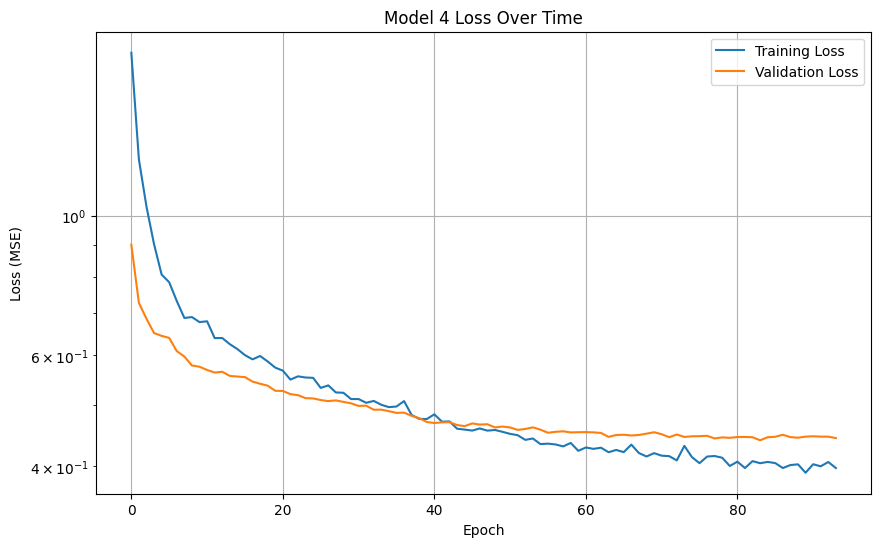

In [14]:
# Set global random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Create copy of df_2 for new model
df_4 = df_2.copy()

# Prepare features (X) and target (y)
X_4 = df_4.drop(['price', 'geoHash'], axis=1)
y_4 = df_4['price']

# Fill NaN values
for column in X_4.columns:
    X_4[column] = X_4[column].fillna(X_4[column].mean())
y_4 = y_4.fillna(y_4.mean())

# Print data statistics before log transform
print("Before log transform:")
print(f"Price mean: {y_4.mean():.2f}")
print(f"Price std: {y_4.std():.2f}")

# Transform target to log space
y_4_log = np.log1p(y_4)

print("\nAfter log transform:")
print(f"Log price mean: {y_4_log.mean():.2f}")
print(f"Log price std: {y_4_log.std():.2f}")

# Scale target variable as well
y_scaler = StandardScaler()
y_4_log_scaled = y_scaler.fit_transform(y_4_log.values.reshape(-1, 1)).flatten()

# Split data using scaled log prices
X_train_val_4, X_test_4, y_train_val_4_log, y_test_4_log = train_test_split(
    X_4, y_4_log_scaled, test_size=0.2, random_state=42, shuffle=True
)

X_train_4, X_val_4, y_train_4_log, y_val_4_log = train_test_split(
    X_train_val_4, y_train_val_4_log, test_size=0.2, random_state=42, shuffle=True
)

# Scale features
scaler_4 = StandardScaler()
X_train_scaled_4 = scaler_4.fit_transform(X_train_4)
X_val_scaled_4 = scaler_4.transform(X_val_4)
X_test_scaled_4 = scaler_4.transform(X_test_4)

# Print shapes and statistics
print("\nData shapes:")
print(f"X_train: {X_train_scaled_4.shape}")
print(f"X_val: {X_val_scaled_4.shape}")
print(f"y_train: {y_train_4_log.shape}")
print(f"y_val: {y_val_4_log.shape}")

print("\nScaled data statistics:")
print(f"X_train mean: {X_train_scaled_4.mean():.4f}, std: {X_train_scaled_4.std():.4f}")
print(f"X_val mean: {X_val_scaled_4.mean():.4f}, std: {X_val_scaled_4.std():.4f}")
print(f"y_train mean: {y_train_4_log.mean():.4f}, std: {y_train_4_log.std():.4f}")
print(f"y_val mean: {y_val_4_log.mean():.4f}, std: {y_val_4_log.std():.4f}")

# Model architecture
model4 = keras.Sequential([
    layers.Input(shape=(X_train_4.shape[1],)),
    layers.Dense(64, activation='relu', 
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.Dropout(0.2, seed=42),
    layers.Dense(32, activation='relu',
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.Dropout(0.2, seed=42),
    layers.Dense(1)
])

# Compile with slightly larger learning rate
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse'
)

# Modified early stopping
early_stopping_4 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=1e-6
)

# Train model4
history4 = model4.fit(
    X_train_scaled_4, y_train_4_log,
    validation_data=(X_val_scaled_4, y_val_4_log),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_4],
    verbose=1
)

# Modified evaluation function
def evaluate_nn_predictions_log(model, X_scaled, y_true_log, set_name):
    y_pred_log = model.predict(X_scaled)
    
    # Inverse transform the scaled log predictions
    y_true_unscaled = y_scaler.inverse_transform(y_true_log.reshape(-1, 1)).flatten()
    y_pred_unscaled = y_scaler.inverse_transform(y_pred_log).flatten()
    
    # Convert back from log space
    y_true = np.expm1(y_true_unscaled)
    y_pred = np.expm1(y_pred_unscaled)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:.2f}")
    print(f"R²: {r2:.3f}")
    
    return rmse, r2

# Evaluate and plot
print("\nModel 4 Results:")
train_rmse, train_r2 = evaluate_nn_predictions_log(model4, X_train_scaled_4, y_train_4_log, "Training")
val_rmse, val_r2 = evaluate_nn_predictions_log(model4, X_val_scaled_4, y_val_4_log, "Validation")
test_rmse, test_r2 = evaluate_nn_predictions_log(model4, X_test_scaled_4, y_test_4_log, "Test")

# Plot loss with both axes scaled
plt.figure(figsize=(10, 6))
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model 4 Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')  # Log scale for y-axis
plt.legend()
plt.grid(True)
plt.show();

In [15]:
# Print final metrics summary for model4
print("\nModel 4 Final Metrics Summary:")
print("-" * 50)
print(f"Training   - RMSE: £{train_rmse:,.2f}, R²: {train_r2:.3f}")
print(f"Validation - RMSE: £{val_rmse:,.2f}, R²: {val_r2:.3f}")
print(f"Test      - RMSE: £{test_rmse:,.2f}, R²: {test_r2:.3f}")
print("-" * 50)

# Add some additional metrics
print("\nDetailed Analysis:")
print("-" * 50)

# Calculate percentage errors
def calculate_percentage_metrics(model, X_scaled, y_true_log):
    y_pred_log = model.predict(X_scaled)
    y_true_unscaled = y_scaler.inverse_transform(y_true_log.reshape(-1, 1)).flatten()
    y_pred_unscaled = y_scaler.inverse_transform(y_pred_log).flatten()
    
    y_true = np.expm1(y_true_unscaled)
    y_pred = np.expm1(y_pred_unscaled)
    
    percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
    
    return {
        'Mean % Error': np.mean(percentage_errors),
        'Median % Error': np.median(percentage_errors),
        'Max % Error': np.max(percentage_errors),
        'Min % Error': np.min(percentage_errors)
    }

# Calculate for each dataset
train_metrics = calculate_percentage_metrics(model4, X_train_scaled_4, y_train_4_log)
val_metrics = calculate_percentage_metrics(model4, X_val_scaled_4, y_val_4_log)
test_metrics = calculate_percentage_metrics(model4, X_test_scaled_4, y_test_4_log)

# Print percentage metrics
for dataset, metrics in [('Training', train_metrics), 
                        ('Validation', val_metrics), 
                        ('Test', test_metrics)]:
    print(f"\n{dataset} Set Percentage Errors:")
    print(f"Mean: {metrics['Mean % Error']:.1f}%")
    print(f"Median: {metrics['Median % Error']:.1f}%")
    print(f"Range: {metrics['Min % Error']:.1f}% to {metrics['Max % Error']:.1f}%")

print("-" * 50)


Model 4 Final Metrics Summary:
--------------------------------------------------
Training   - RMSE: £1,631.37, R²: 0.739
Validation - RMSE: £2,283.29, R²: 0.596
Test      - RMSE: £1,530.17, R²: 0.726
--------------------------------------------------

Detailed Analysis:
--------------------------------------------------
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step

Training Set Percentage Errors:
Mean: 40.2%
Median: 22.8%
Range: 0.0% to 5781.8%

Validation Set Percentage Errors:
Mean: 117.1%
Median: 25.4%
Range: 0.0% to 93317.6%

Test Set Percentage Errors:
Mean: 46.1%
Median: 25.8%
Range: 0.0% to 510.1%
--------------------------------------------------


In [16]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,333 (325.52 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,556 (217.02 KB)

Finally, we have a model that performs better than our randomforest regressor. Now we can iterate on this model and improve it.

## Model Tweaking/Improving

Model 4a is exactly the same as model 4 and uses the same data preprocessing, but it has no dropout layers and a lower learning rate.

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.7409 - val_loss: 1.2102
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 1.0486 - val_loss: 0.9113
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.8183 - val_loss: 0.7776
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.7122 - val_loss: 0.7044
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.6538 - val_loss: 0.6604
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.6166 - val_loss: 0.6306
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.5898 - val_loss: 0.6106
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.5713 - val_loss: 0.5954
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.5565 - val_loss: 0.5847
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.5456 - val_loss: 0.5770
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.5365 - val_loss: 0.5714
Epoch 12/100
156/15

2025-02-10 14:43:29.440234: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:43:29.440511: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Model 4a Loss Over Time')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss (MSE)')

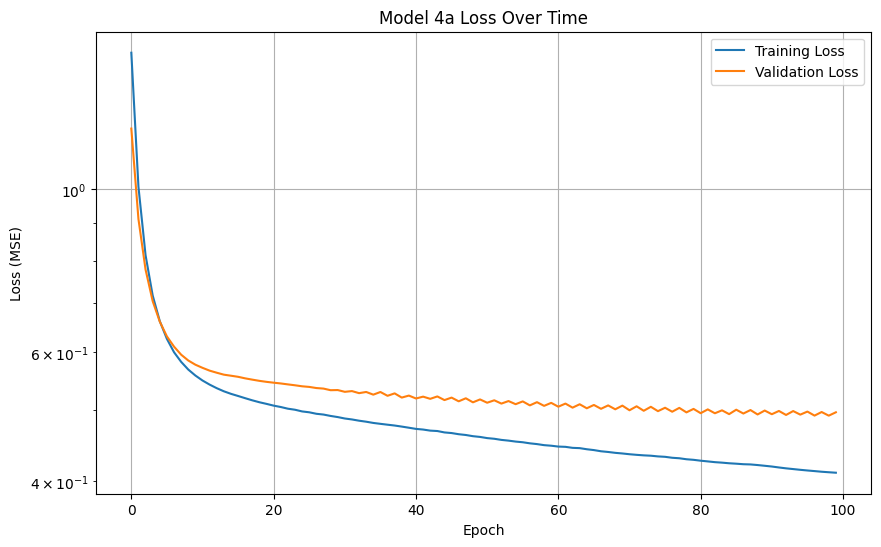


Model 4a Final Metrics Summary:
--------------------------------------------------
Training   - RMSE: £1,671.17, R²: 0.726
Validation - RMSE: £2,127.79, R²: 0.649
Test       - RMSE: £1,647.97, R²: 0.682


In [17]:
# Set global random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Model 4a: Same as Model 4 but without dropout and lower learning rate
model4a = keras.Sequential([
    layers.Input(shape=(X_train_4.shape[1],)),
    layers.Dense(64, activation='relu', 
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.Dense(32, activation='relu',
                kernel_initializer=keras.initializers.HeNormal(seed=42)),
    layers.Dense(1)
])

# Compile with lower learning rate
model4a.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='mse'
)

# Same early stopping as Model 4
early_stopping_4a = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=1e-6
)

# Train model4a using same data as Model 4
history4a = model4a.fit(
    X_train_scaled_4, y_train_4_log,
    validation_data=(X_val_scaled_4, y_val_4_log),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_4a],
    verbose=1
)

# Define the exact same evaluation function as Model 4
def evaluate_nn_predictions_log(model, X_scaled, y_true_log, set_name):
    y_pred_log = model.predict(X_scaled)
    
    # First, inverse transform the standardized values
    y_true_unscaled = y_scaler.inverse_transform(y_true_log.reshape(-1, 1)).flatten()
    y_pred_unscaled = y_scaler.inverse_transform(y_pred_log).flatten()
    
    # Then, convert from log space back to original prices
    y_true = np.expm1(y_true_unscaled)
    y_pred = np.expm1(y_pred_unscaled)
    
    # Calculate metrics on the original price scale
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:,.2f}")  # Added thousands separator
    print(f"R²: {r2:.3f}")
    
    # Print some debugging information
    print(f"\nDebug info for {set_name}:")
    print(f"Price range (true): £{y_true.min():,.2f} to £{y_true.max():,.2f}")
    print(f"Price range (pred): £{y_pred.min():,.2f} to £{y_pred.max():,.2f}")
    
    return rmse, r2

# Evaluate using the corrected evaluation function
print("\nModel 4a Results:")
train_rmse, train_r2 = evaluate_nn_predictions_log(model4a, X_train_scaled_4, y_train_4_log, "Training")
val_rmse, val_r2 = evaluate_nn_predictions_log(model4a, X_val_scaled_4, y_val_4_log, "Validation")
test_rmse, test_r2 = evaluate_nn_predictions_log(model4a, X_test_scaled_4, y_test_4_log, "Test")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history4a.history['loss'], label='Training Loss')
plt.plot(history4a.history['val_loss'], label='Validation Loss')
plt.title('Model 4a Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print final metrics summary for model4a
print("\nModel 4a Final Metrics Summary:")
print("-" * 50)
print(f"Training   - RMSE: £{train_rmse:,.2f}, R²: {train_r2:.3f}")
print(f"Validation - RMSE: £{val_rmse:,.2f}, R²: {val_r2:.3f}")
print(f"Test       - RMSE: £{test_rmse:,.2f}, R²: {test_r2:.3f}")

Model performs slightly worse, we are seeing validation loss increase after 10 epochs suggesting the model is now overfitting the data. 

Model 4b makes the following changes to combat overfitting

Architecture:

    Reduced Layer sizes (32, 16, 1)
    Added L2 regularization to dense layers
    Added BatchNormalization layers
    Added light dropout layers

Training parameters

    Further reduced learning rate (0.00005)
    Added gradient clipping
    Increased batch size to 64
    Added ReduceLROnPlateau callback
    Increased early stopping patience

Regularization techniques:

    L2 regularization (weight decay)
    Batch normalization
    Light dropout
    Gradient clipping

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2475 - val_loss: 2.5744 - learning_rate: 5.0000e-05
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.0205 - val_loss: 2.3962 - learning_rate: 5.0000e-05
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.7933 - val_loss: 2.2678 - learning_rate: 5.0000e-05
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 2.6875 - val_loss: 2.1658 - learning_rate: 5.0000e-05
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 2.5426 - val_loss: 2.0664 - learning_rate: 5.0000e-05
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 2.3609 - val_loss: 1.9891 - learning_rate: 5.0000e-05
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 2.3117 - val_loss: 1.9135 - learning_rate: 5.0000e-05
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2192 - val_loss: 1.8508 - learning_rate: 5.0000e-05
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 2.1166 - val_loss: 1.78

2025-02-10 14:43:38.803030: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:43:38.803314: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Validation Results:
RMSE: £5,174.21
R²: -1.073

Debug info for Validation:
Price range (true): £1.00 to £78,000.00
Price range (pred): £884.46 to £220,519.14
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step

Test Results:
RMSE: £1,942.85
R²: 0.558

Debug info for Test:
Price range (true): £125.00 to £65,000.00
Price range (pred): £867.31 to £39,140.43


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Model 4b Loss Over Time')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss (MSE)')

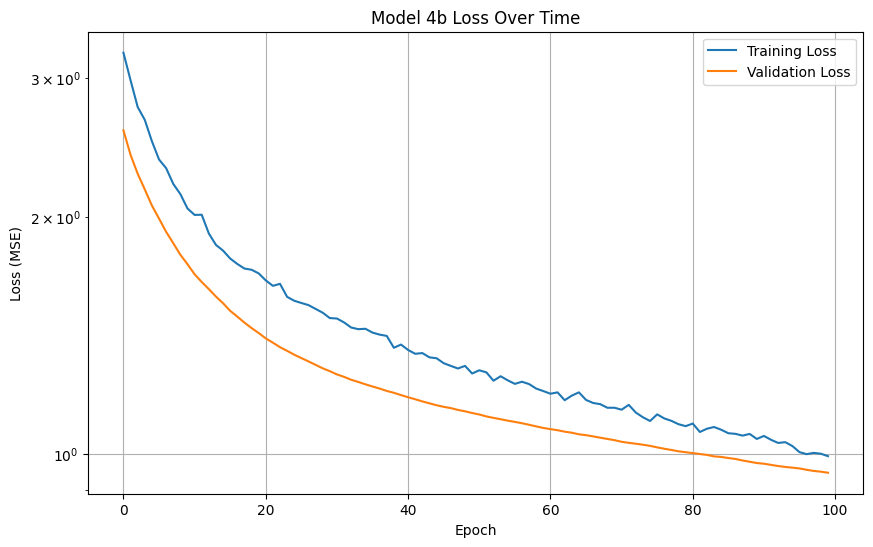


Model 4b Final Metrics Summary:
--------------------------------------------------
Training   - RMSE: £66,881.42, R²: -437.106
Validation - RMSE: £5,174.21, R²: -1.073
Test       - RMSE: £1,942.85, R²: 0.558


In [18]:
# Set global random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Model 4b: Adding regularization to combat overfitting
model4b = keras.Sequential([
    layers.Input(shape=(X_train_4.shape[1],)),
    
    # Add L2 regularization and smaller layers
    layers.Dense(32, activation='relu', 
                kernel_initializer=keras.initializers.HeNormal(seed=42),
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2, seed=42),
    
    layers.Dense(16, activation='relu',
                kernel_initializer=keras.initializers.HeNormal(seed=42),
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.1, seed=42),
    
    layers.Dense(1)
])

# Compile with even lower learning rate and gradient clipping
model4b.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.00005,  # Lower learning rate
        clipnorm=1.0  # Gradient clipping
    ),
    loss='mse'
)

# Modified callbacks
early_stopping_4b = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=1e-6
)

reduce_lr_4b = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model4b using same data as Model 4
history4b = model4b.fit(
    X_train_scaled_4, y_train_4_log,
    validation_data=(X_val_scaled_4, y_val_4_log),
    epochs=100,
    batch_size=64,  # Increased batch size for more stable training
    callbacks=[early_stopping_4b, reduce_lr_4b],
    verbose=1
)

# Evaluate using same evaluation function
print("\nModel 4b Results:")
train_rmse, train_r2 = evaluate_nn_predictions_log(model4b, X_train_scaled_4, y_train_4_log, "Training")
val_rmse, val_r2 = evaluate_nn_predictions_log(model4b, X_val_scaled_4, y_val_4_log, "Validation")
test_rmse, test_r2 = evaluate_nn_predictions_log(model4b, X_test_scaled_4, y_test_4_log, "Test")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history4b.history['loss'], label='Training Loss')
plt.plot(history4b.history['val_loss'], label='Validation Loss')
plt.title('Model 4b Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print final metrics summary for model4b
print("\nModel 4b Final Metrics Summary:")
print("-" * 50)
print(f"Training   - RMSE: £{train_rmse:,.2f}, R²: {train_r2:.3f}")
print(f"Validation - RMSE: £{val_rmse:,.2f}, R²: {val_r2:.3f}")
print(f"Test       - RMSE: £{test_rmse:,.2f}, R²: {test_r2:.3f}")


Validation set performance on 4a better than 4, Create an ensemble of both and test


Ensemble Model Results:
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step

Training Results:
RMSE: £1,617.00
R²: 0.744
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


2025-02-10 14:57:02.045046: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-02-10 14:57:02.045406: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step

Validation Results:
RMSE: £2,201.07
R²: 0.625
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step

Test Results:
RMSE: £1,429.51
R²: 0.761


<Figure size 1000x600 with 0 Axes>

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


Text(0.5, 1.0, 'Ensemble Predictions vs Actual')

Text(0.5, 0, 'Actual Price (£)')

Text(0, 0.5, 'Predicted Price (£)')

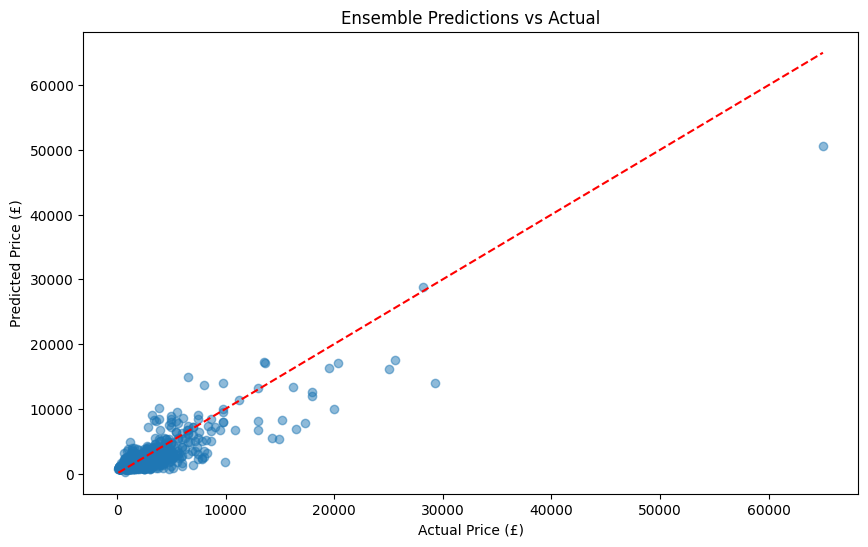

In [21]:
# 1. Create ensemble prediction function
def ensemble_predict(model4, model4a, X_scaled):
    # Get predictions from both models
    pred4 = model4.predict(X_scaled)
    pred4a = model4a.predict(X_scaled)
    
    # Average the predictions (can try different weights too)
    ensemble_pred = 0.7 * pred4 + 0.3 * pred4a  # Weighted towards model4
    
    return ensemble_pred

# 2. Modified evaluation function for ensemble
def evaluate_ensemble_predictions(y_pred_log, y_true_log, set_name):
    # Inverse transform the scaled log predictions
    y_true_unscaled = y_scaler.inverse_transform(y_true_log.reshape(-1, 1)).flatten()
    y_pred_unscaled = y_scaler.inverse_transform(y_pred_log).flatten()
    
    # Convert back from log space
    y_true = np.expm1(y_true_unscaled)
    y_pred = np.expm1(y_pred_unscaled)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Results:")
    print(f"RMSE: £{rmse:,.2f}")
    print(f"R²: {r2:.3f}")
    
    return rmse, r2

# 3. Evaluate ensemble
print("\nEnsemble Model Results:")
# Training
y_train_pred = ensemble_predict(model4, model4a, X_train_scaled_4)
train_rmse, train_r2 = evaluate_ensemble_predictions(y_train_pred, y_train_4_log, "Training")

# Validation
y_val_pred = ensemble_predict(model4, model4a, X_val_scaled_4)
val_rmse, val_r2 = evaluate_ensemble_predictions(y_val_pred, y_val_4_log, "Validation")

# Test
y_test_pred = ensemble_predict(model4, model4a, X_test_scaled_4)
test_rmse, test_r2 = evaluate_ensemble_predictions(y_test_pred, y_test_4_log, "Test")

# 4. Visualize results
plt.figure(figsize=(10, 6))
test_preds = ensemble_predict(model4, model4a, X_test_scaled_4)
test_true_unscaled = y_scaler.inverse_transform(y_test_4_log.reshape(-1, 1)).flatten()
test_pred_unscaled = y_scaler.inverse_transform(test_preds).flatten()

test_true_price = np.expm1(test_true_unscaled)
test_pred_price = np.expm1(test_pred_unscaled)

plt.scatter(test_true_price, test_pred_price, alpha=0.5)
plt.plot([test_true_price.min(), test_true_price.max()], 
         [test_true_price.min(), test_true_price.max()], 'r--')
plt.title('Ensemble Predictions vs Actual')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.show()


Ensemble Model is even better, but note that when we visualise we see that the model struggles with very expensive properties as they are outliers, perhaps the next step is to eliminate these outliers as to not affect model performance. 

So far the Ensemble model is the best, can we use it but change so that it is predicting what band of prices the property should be in instead of exact price, would this be more accurate? Is it better to predict the band or to predict raw number and then allocate to a band?


## Additional Testing of Selected Model

## Model Visualisation